# Google Stock Price Prediction using LSTM

# 1. Importing Library

In [1]:
# First we will import the necessary Library 

import os
import pandas as pd
import numpy as np
import math
import datetime as dt

# For Evalution we will use these library

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler

# For model building we will use these library

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler


# For PLotting we will use these library

import matplotlib.pyplot as plt
from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

from plotly.offline import init_notebook_mode,iplot
init_notebook_mode(connected=True)

import warnings

warnings.filterwarnings('ignore', category=FutureWarning, message='The behavior of DatetimeProperties.to_pydatetime is deprecated')


/Users/shahidali/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/shahidali/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (
2024-05-27 20:47:58.387098: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# 2. Loading Dataset

In [2]:
# Load our dataset 
df=pd.read_csv('Dataset.csv')

# Check head and tail of the dataset

In [3]:
df.head()

Unnamed: 0        Date       Open       High        Low      Close  \
0           0  2013-01-02  17.918339  18.107130  17.846855  18.013729   
1           1  2013-01-03  18.055573  18.229919  17.950716  18.024191   
2           2  2013-01-04  18.165413  18.467529  18.124067  18.380356   
3           3  2013-01-07  18.317591  18.415474  18.196297  18.300158   
4           4  2013-01-08  18.319834  18.338762  18.043119  18.264042   

      Volume  
0  102033017  
1   93075567  
2  110954331  
3   66476239  
4   67295297

In [4]:
df.tail()

Unnamed: 0        Date        Open        High         Low       Close  \
2770        2770  2024-01-04  139.850006  140.634995  138.009995  138.039993   
2771        2771  2024-01-05  138.352005  138.809998  136.850006  137.389999   
2772        2772  2024-01-08  138.000000  140.639999  137.880005  140.529999   
2773        2773  2024-01-09  140.059998  142.800003  139.789993  142.559998   
2774        2774  2024-01-10  142.520004  144.524994  142.460007  143.800003   

        Volume  
2770  18253300  
2771  15433200  
2772  17645300  
2773  19579700  
2774  16621800

# Remove Any Duplicates values

In [5]:
# Remove any duplicate index 
df = df.loc[~df.index.duplicated(keep='first')]

In [6]:
print('Total number of days present in the dataset: ',df.shape[0])
print('Total number of fields present in the dataset: ',df.shape[1])

Total number of days present in the dataset:  2775
Total number of fields present in the dataset:  7


# Check the shape of the dataset

In [7]:
df.shape

(2775, 7)

In [8]:
df.head()

Unnamed: 0        Date       Open       High        Low      Close  \
0           0  2013-01-02  17.918339  18.107130  17.846855  18.013729   
1           1  2013-01-03  18.055573  18.229919  17.950716  18.024191   
2           2  2013-01-04  18.165413  18.467529  18.124067  18.380356   
3           3  2013-01-07  18.317591  18.415474  18.196297  18.300158   
4           4  2013-01-08  18.319834  18.338762  18.043119  18.264042   

      Volume  
0  102033017  
1   93075567  
2  110954331  
3   66476239  
4   67295297

# Now Check the Statistical Analysis of the dataset

In [9]:
df

Unnamed: 0        Date        Open        High         Low       Close  \
0              0  2013-01-02   17.918339   18.107130   17.846855   18.013729   
1              1  2013-01-03   18.055573   18.229919   17.950716   18.024191   
2              2  2013-01-04   18.165413   18.467529   18.124067   18.380356   
3              3  2013-01-07   18.317591   18.415474   18.196297   18.300158   
4              4  2013-01-08   18.319834   18.338762   18.043119   18.264042   
...          ...         ...         ...         ...         ...         ...   
2770        2770  2024-01-04  139.850006  140.634995  138.009995  138.039993   
2771        2771  2024-01-05  138.352005  138.809998  136.850006  137.389999   
2772        2772  2024-01-08  138.000000  140.639999  137.880005  140.529999   
2773        2773  2024-01-09  140.059998  142.800003  139.789993  142.559998   
2774        2774  2024-01-10  142.520004  144.524994  142.460007  143.800003   

         Volume  
0     102033017  
1      93075567  
2     110954331  
3      66476239  
4      67295297  
...         ...  
2770   18253300  
2771   15433200  
2772   17645300  
2773   19579700  
2774   16621800  

[2775 rows x 7 columns]

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2775 entries, 0 to 2774
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  2775 non-null   int64  
 1   Date        2775 non-null   object 
 2   Open        2775 non-null   float64
 3   High        2775 non-null   float64
 4   Low         2775 non-null   float64
 5   Close       2775 non-null   float64
 6   Volume      2775 non-null   int64  
dtypes: float64(4), int64(2), object(1)
memory usage: 173.4+ KB


In [11]:
df.describe()

Unnamed: 0         Open         High          Low        Close  \
count  2775.000000  2775.000000  2775.000000  2775.000000  2775.000000   
mean   1387.000000    64.913671    65.600115    64.273645    64.952090   
std     801.217823    38.164394    38.630869    37.753744    38.194190   
min       0.000000    17.550716    17.567652    17.323069    17.506132   
25%     693.500000    32.755501    33.153002    32.346251    32.710751   
50%    1387.000000    54.200001    54.778500    53.616100    54.249500   
75%    2080.500000    94.466000    96.004997    93.208252    94.619999   
max    2774.000000   151.863495   152.100006   149.887497   150.709000   

             Volume  
count  2.775000e+03  
mean   3.828731e+07  
std    2.612174e+07  
min    1.584340e+05  
25%    2.356953e+07  
50%    3.023200e+07  
75%    4.305293e+07  
max    4.643901e+08

# Checking for Null Values

In [12]:
print('Null Values:',df.isnull().values.sum())

Null Values: 0


In [13]:
print('NA values:',df.isnull().values.any())

NA values: False


In [14]:
# If dataset had null values we can use this code to drop all the null values present in the dataset

df=df.dropna()
print('Null Values:',df.isnull().values.sum())
print('NA values:',df.isnull().values.any())

Null Values: 0
NA values: False


In [15]:
# Final shape of the dataset after dealing with null values 

df.shape

(2775, 7)

# 3. EDA(Exploratory Data Analysis)

In [16]:
# Printing the start date and End date of the dataset

sd=df.iloc[0][1]
ed=df.iloc[-1][1]


print('Starting Date',sd)
print('Ending Date',ed)


Starting Date 2013-01-02
Ending Date 2024-01-10


/var/folders/1_/pw6chw914c1fzbdz4kf_c2d00000gn/T/ipykernel_5032/3139843101.py:3: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/var/folders/1_/pw6chw914c1fzbdz4kf_c2d00000gn/T/ipykernel_5032/3139843101.py:4: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



# StockPrice Analysis from Start

# Analysis of year 2013

In [17]:
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

y_2013 = df.loc[(df['Date'] >= '2013-01-01')
                     & (df['Date'] < '2013-12-31')]

y_2013.drop(y_2013[['Close','Volume']],axis=1)

Unnamed: 0       Date       Open       High        Low
0             0 2013-01-02  17.918339  18.107130  17.846855
1             1 2013-01-03  18.055573  18.229919  17.950716
2             2 2013-01-04  18.165413  18.467529  18.124067
3             3 2013-01-07  18.317591  18.415474  18.196297
4             4 2013-01-08  18.319834  18.338762  18.043119
..          ...        ...        ...        ...        ...
246         246 2013-12-23  27.592575  27.790833  27.524830
247         247 2013-12-24  27.770161  27.776884  27.599052
248         248 2013-12-26  27.746250  27.870535  27.613747
249         249 2013-12-27  27.895441  27.902414  27.719601
250         250 2013-12-30  27.903910  27.907894  27.621965

[251 rows x 5 columns]

In [18]:
monthvise= y_2013.groupby(y_2013['Date'].dt.strftime('%B'))[['Open','Close']].mean()
new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 
             'September', 'October', 'November', 'December']
monthvise = monthvise.reindex(new_order, axis=0)
monthvise

Open      Close
Date                           
January    18.269616  18.286114
February   19.525602  19.575272
March      20.389936  20.373224
April      19.806408  19.835787
May        21.782830  21.834115
June       21.876576  21.849540
July       22.456079  22.451290
August     21.849206  21.794400
September  22.030649  22.049752
October    23.305655  23.379737
November   25.655263  25.675126
December   26.945539  26.962264

In [19]:
fig = go.Figure()

fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['Open'],
    name='Google Stock Open Price',
    marker_color='crimson'
))
fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['Close'],
    name='Google Stock Close Price',
    marker_color='lightsalmon'
))

fig.update_layout(barmode='group', xaxis_tickangle=-45, 
                  title='Monthwise comparision between Google open and close price')
fig.show()

In [20]:
y_2013.groupby(y_2013['Date'].dt.strftime('%B'))['Low'].min()
monthvise_high = y_2013.groupby(df['Date'].dt.strftime('%B'))['High'].max()
monthvise_high = monthvise_high.reindex(new_order, axis=0)

monthvise_low = y_2013.groupby(y_2013['Date'].dt.strftime('%B'))['Low'].min()
monthvise_low = monthvise_low.reindex(new_order, axis=0)

fig = go.Figure()
fig.add_trace(go.Bar(
    x=monthvise_high.index,
    y=monthvise_high,
    name='Google Stock high Price',
    marker_color='rgb(0, 153, 204)'
))
fig.add_trace(go.Bar(
    x=monthvise_low.index,
    y=monthvise_low,
    name='Google Stock low Price',
    marker_color='rgb(255, 128, 0)'
))

fig.update_layout(barmode='group', 
                  title=' Monthwise High and Low Google Stock Price')
fig.show()

In [21]:
names = cycle(['Google Stock Open Price','Google Stock Close Price','Google Stock High Price','Google Stock Low Price'])

fig = px.line(y_2013, x=y_2013.Date, y=[y_2013['Open'], y_2013['Close'], 
                                          y_2013['High'], y_2013['Low']],
             labels={'Date': 'Date','value':'Google value'})
fig.update_layout(title_text='Google Stock analysis chart', font_size=15, font_color='black',legend_title_text='Google Stock Parameters')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.show()

# Analysis of year 2014

In [22]:
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

y_2014 = df.loc[(df['Date'] >= '2014-01-01')
                     & (df['Date'] < '2014-12-31')]

y_2014.drop(y_2014[['Close','Volume']],axis=1)

Unnamed: 0       Date       Open       High        Low
252         252 2014-01-02  27.782366  27.839401  27.603037
253         253 2014-01-03  27.770908  27.818977  27.520098
254         254 2014-01-06  27.721344  27.867046  27.557707
255         255 2014-01-07  28.019974  28.385853  27.924334
256         256 2014-01-08  28.543015  28.575891  28.226450
..          ...        ...        ...        ...        ...
498         498 2014-12-23  26.277855  26.654819  26.242451
499         499 2014-12-24  26.452873  26.515154  26.278851
500         500 2014-12-26  26.366112  26.639362  26.293312
501         501 2014-12-29  26.536644  26.700693  26.427992
502         502 2014-12-30  26.332205  26.484785  26.284336

[251 rows x 5 columns]

In [23]:
monthvise= y_2014.groupby(y_2014['Date'].dt.strftime('%B'))[['Open','Close']].mean()
new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 
             'September', 'October', 'November', 'December']
monthvise = monthvise.reindex(new_order, axis=0)
monthvise

Open      Close
Date                           
January    28.382651  28.303281
February   29.623634  29.643297
March      29.652465  29.456970
April      27.124055  26.927499
May        26.583824  26.629555
June       27.815822  27.845075
July       29.127372  29.120833
August     28.629089  28.601508
September  28.998527  29.014792
October    27.341738  27.276612
November   27.138439  27.074562
December   26.161673  26.155310

In [24]:
fig = go.Figure()

fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['Open'],
    name='Google Stock Open Price',
    marker_color='crimson'
))
fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['Close'],
    name='Google Stock Close Price',
    marker_color='lightsalmon'
))

fig.update_layout(barmode='group', xaxis_tickangle=-45, 
                  title='Monthwise comparision between Google Stock open and close price')
fig.show()

In [25]:
y_2014.groupby(y_2014['Date'].dt.strftime('%B'))['Low'].min()
monthvise_high = y_2014.groupby(df['Date'].dt.strftime('%B'))['High'].max()
monthvise_high = monthvise_high.reindex(new_order, axis=0)

monthvise_low = y_2014.groupby(y_2014['Date'].dt.strftime('%B'))['Low'].min()
monthvise_low = monthvise_low.reindex(new_order, axis=0)

fig = go.Figure()
fig.add_trace(go.Bar(
    x=monthvise_high.index,
    y=monthvise_high,
    name='Google Stock high Price',
    marker_color='rgb(0, 153, 204)'
))
fig.add_trace(go.Bar(
    x=monthvise_low.index,
    y=monthvise_low,
    name='Google Stock low Price',
    marker_color='rgb(255, 128, 0)'
))

fig.update_layout(barmode='group', 
                  title=' Monthwise High and Low Google Stock price')
fig.show()

In [26]:
names = cycle(['Google Stock Open Price','Google Stock Close Price','Google Stock High Price','Google Stock Low Price'])

fig = px.line(y_2014, x=y_2014.Date, y=[y_2014['Open'], y_2014['Close'], 
                                          y_2014['High'], y_2014['Low']],
             labels={'Date': 'Date','value':'Google Stock value'})
fig.update_layout(title_text='Google Stock analysis chart', font_size=15, font_color='black',legend_title_text='Google Stock Parameters')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.show()

# Analysis of Year 2015

In [27]:
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

y_2015 = df.loc[(df['Date'] >= '2015-01-01')
                     & (df['Date'] < '2016-01-01')]

y_2015.drop(y_2015[['Close','Volume']],axis=1)

Unnamed: 0       Date       Open       High        Low
504         504 2015-01-02  26.378078  26.490770  26.133251
505         505 2015-01-05  26.091366  26.144720  25.582764
506         506 2015-01-06  25.679497  25.738087  24.983908
507         507 2015-01-07  25.280592  25.292759  24.914099
508         508 2015-01-08  24.831326  25.105074  24.482782
..          ...        ...        ...        ...        ...
751         751 2015-12-24  37.477501  37.567501  37.331001
752         752 2015-12-28  37.646000  38.149502  37.476002
753         753 2015-12-29  38.334499  38.999001  38.321499
754         754 2015-12-30  38.830002  38.880001  38.345001
755         755 2015-12-31  38.474998  38.474998  37.917000

[252 rows x 5 columns]

In [28]:
monthvise= y_2015.groupby(y_2015['Date'].dt.strftime('%B'))[['Open','Close']].mean()
new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 
             'September', 'October', 'November', 'December']
monthvise = monthvise.reindex(new_order, axis=0)
monthvise

Open      Close
Date                           
January    25.590965  25.550750
February   26.722423  26.825955
March      27.941264  27.909194
April      26.998340  26.965223
May        26.773525  26.761950
June       26.691739  26.645795
July       29.410023  29.504682
August     31.971362  31.841904
September  30.939810  30.896738
October    33.114296  33.179637
November   36.681800  36.769425
December   37.804977  37.767727

In [29]:
fig = go.Figure()

fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['Open'],
    name='Google Stock Open Price',
    marker_color='crimson'
))
fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['Close'],
    name='Google Stock Close Price',
    marker_color='lightsalmon'
))

fig.update_layout(barmode='group', xaxis_tickangle=-45, 
                  title='Monthwise comparision between Google Stock open and close price')
fig.show()

In [30]:
y_2015.groupby(y_2015['Date'].dt.strftime('%B'))['Low'].min()
monthvise_high = y_2015.groupby(df['Date'].dt.strftime('%B'))['High'].max()
monthvise_high = monthvise_high.reindex(new_order, axis=0)

monthvise_low = y_2015.groupby(y_2015['Date'].dt.strftime('%B'))['Low'].min()
monthvise_low = monthvise_low.reindex(new_order, axis=0)

fig = go.Figure()
fig.add_trace(go.Bar(
    x=monthvise_high.index,
    y=monthvise_high,
    name='Google Stock high Price',
    marker_color='rgb(0, 153, 204)'
))
fig.add_trace(go.Bar(
    x=monthvise_low.index,
    y=monthvise_low,
    name='Google Stock low Price',
    marker_color='rgb(255, 128, 0)'
))

fig.update_layout(barmode='group', 
                  title=' Monthwise High and Low Google Stock price')
fig.show()

In [31]:
names = cycle(['Google Stock Open Price','Google Stock Close Price','Google Stock High Price','Google Stock Low Price'])

fig = px.line(y_2015, x=y_2015.Date, y=[y_2015['Open'], y_2015['Close'], 
                                          y_2015['High'], y_2015['Low']],
             labels={'Date': 'Date','value':'Google Stock value'})
fig.update_layout(title_text='Google Stock analysis chart', font_size=15, font_color='black',legend_title_text='Google Stock Parameters')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.show()

# Analysis of Year 2016

In [32]:
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

y_2016 = df.loc[(df['Date'] >= '2016-01-01')
                     & (df['Date'] < '2017-01-01')]

y_2016.drop(y_2016[['Close','Volume']],axis=1)

Unnamed: 0       Date       Open       High        Low
756          756 2016-01-04  37.150002  37.202999  36.562901
757          757 2016-01-05  37.322498  37.599998  36.931999
758          758 2016-01-06  36.500000  37.359001  36.445999
759          759 2016-01-07  36.515499  36.924999  35.952999
760          760 2016-01-08  36.572498  36.661499  35.650002
...          ...        ...        ...        ...        ...
1003        1003 2016-12-23  39.544998  39.637001  39.363998
1004        1004 2016-12-27  39.534000  39.893002  39.382851
1005        1005 2016-12-28  39.685001  39.711498  39.160000
1006        1006 2016-12-29  39.166500  39.296501  38.945999
1007        1007 2016-12-30  39.137501  39.139000  38.520500

[252 rows x 5 columns]

In [33]:
monthvise= y_2016.groupby(y_2016['Date'].dt.strftime('%B'))[['Open','Close']].mean()
new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 
             'September', 'October', 'November', 'December']
monthvise = monthvise.reindex(new_order, axis=0)
monthvise

Open      Close
Date                           
January    35.975158  35.924789
February   35.317450  35.134450
March      36.263273  36.352841
April      36.922286  36.841690
May        35.494667  35.609143
June       35.386796  35.324318
July       36.209525  36.285975
August     38.724130  38.789674
September  38.644738  38.680977
October    39.514715  39.422476
November   38.403429  38.332048
December   39.115643  39.108572

In [34]:
fig = go.Figure()

fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['Open'],
    name='Google Stock Open Price',
    marker_color='crimson'
))
fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['Close'],
    name='Google Stock Close Price',
    marker_color='lightsalmon'
))

fig.update_layout(barmode='group', xaxis_tickangle=-45, 
                  title='Monthwise comparision between Google Stock open and close price')
fig.show()

In [35]:
y_2016.groupby(y_2016['Date'].dt.strftime('%B'))['Low'].min()
monthvise_high = y_2016.groupby(df['Date'].dt.strftime('%B'))['High'].max()
monthvise_high = monthvise_high.reindex(new_order, axis=0)

monthvise_low = y_2016.groupby(y_2016['Date'].dt.strftime('%B'))['Low'].min()
monthvise_low = monthvise_low.reindex(new_order, axis=0)

fig = go.Figure()
fig.add_trace(go.Bar(
    x=monthvise_high.index,
    y=monthvise_high,
    name='Google Stock high Price',
    marker_color='rgb(0, 153, 204)'
))
fig.add_trace(go.Bar(
    x=monthvise_low.index,
    y=monthvise_low,
    name='Google Stock low Price',
    marker_color='rgb(255, 128, 0)'
))

fig.update_layout(barmode='group', 
                  title=' Monthwise High and Low Google Stock price')
fig.show()

In [36]:
names = cycle(['Google Stock Open Price','Google Stock Close Price','Google Stock High Price','Google Stock Low Price'])

fig = px.line(y_2016, x=y_2016.Date, y=[y_2016['Open'], y_2016['Close'], 
                                          y_2016['High'], y_2016['Low']],
             labels={'Date': 'Date','value':'Google Stock value'})
fig.update_layout(title_text='Google Stock analysis chart', font_size=15, font_color='black',legend_title_text='Google Stock Parameters')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.show()

# Analysis of Year 2017

In [37]:
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

y_2017 = df.loc[(df['Date'] >= '2017-01-01')
                     & (df['Date'] < '2018-01-01')]

y_2017.drop(y_2017[['Close','Volume']],axis=1)

Unnamed: 0       Date       Open       High        Low
1008        1008 2017-01-03  38.940498  39.481499  38.790001
1009        1009 2017-01-04  39.417999  39.567001  39.158001
1010        1010 2017-01-05  39.304001  39.723999  39.250999
1011        1011 2017-01-06  39.763000  40.395000  39.610199
1012        1012 2017-01-09  40.320000  40.498299  40.141499
...          ...        ...        ...        ...        ...
1254        1254 2017-12-22  53.055500  53.209999  52.972000
1255        1255 2017-12-26  52.903500  53.006001  52.509998
1256        1256 2017-12-27  52.869499  52.918499  52.402500
1257        1257 2017-12-28  52.580002  52.737499  52.238499
1258        1258 2017-12-29  52.335999  52.485001  52.244999

[251 rows x 5 columns]

In [38]:
monthvise= y_2017.groupby(y_2017['Date'].dt.strftime('%B'))[['Open','Close']].mean()
new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 
             'September', 'October', 'November', 'December']
monthvise = monthvise.reindex(new_order, axis=0)
monthvise

Open      Close
Date                           
January    40.376300  40.395238
February   40.765816  40.845829
March      41.707609  41.705565
April      42.128026  42.202843
May        46.834727  46.964205
June       47.827977  47.688341
July       47.085150  47.143250
August     46.083065  46.101152
September  46.543550  46.564975
October    49.096000  49.126114
November   51.439619  51.524642
December   52.143950  52.182650

In [39]:
fig = go.Figure()

fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['Open'],
    name='Stock Open Price',
    marker_color='crimson'
))
fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['Close'],
    name='Stock Close Price',
    marker_color='lightsalmon'
))

fig.update_layout(barmode='group', xaxis_tickangle=-45, 
                  title='Monthwise comparision between Stock open and close price')
fig.show()

In [40]:
y_2017.groupby(y_2017['Date'].dt.strftime('%B'))['Low'].min()
monthvise_high = y_2017.groupby(df['Date'].dt.strftime('%B'))['High'].max()
monthvise_high = monthvise_high.reindex(new_order, axis=0)

monthvise_low = y_2017.groupby(y_2017['Date'].dt.strftime('%B'))['Low'].min()
monthvise_low = monthvise_low.reindex(new_order, axis=0)

fig = go.Figure()
fig.add_trace(go.Bar(
    x=monthvise_high.index,
    y=monthvise_high,
    name='Stock high Price',
    marker_color='rgb(0, 153, 204)'
))
fig.add_trace(go.Bar(
    x=monthvise_low.index,
    y=monthvise_low,
    name='Stock low Price',
    marker_color='rgb(255, 128, 0)'
))

fig.update_layout(barmode='group', 
                  title=' Monthwise High and Low Google Stock price')
fig.show()

In [41]:
names = cycle(['Stock Open Price','Stock Close Price','Stock High Price','Stock Low Price'])

fig = px.line(y_2017, x=y_2017.Date, y=[y_2017['Open'], y_2017['Close'], 
                                          y_2017['High'], y_2017['Low']],
             labels={'Date': 'Date','value':'Stock value'})
fig.update_layout(title_text='Google Stock analysis chart', font_size=15, font_color='black',legend_title_text='Google Stock Parameters')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.show()

# Analysis of Year 2018

In [42]:
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

y_2018 = df.loc[(df['Date'] >= '2018-01-01')
                     & (df['Date'] < '2019-01-01')]

y_2018.drop(y_2018[['Close','Volume']],axis=1)

Unnamed: 0       Date       Open       High        Low
1259        1259 2018-01-02  52.417000  53.347000  52.261501
1260        1260 2018-01-03  53.215500  54.314499  53.160500
1261        1261 2018-01-04  54.400002  54.678501  54.200100
1262        1262 2018-01-05  54.700001  55.212502  54.599998
1263        1263 2018-01-08  55.111500  55.563499  55.081001
...          ...        ...        ...        ...        ...
1505        1505 2018-12-24  48.695000  50.176998  48.505501
1506        1506 2018-12-26  49.450500  52.000000  49.150002
1507        1507 2018-12-27  50.857498  52.194500  49.849998
1508        1508 2018-12-28  52.480999  52.778000  51.654999
1509        1509 2018-12-31  52.548000  52.634998  51.179501

[251 rows x 5 columns]

In [43]:
monthvise= y_2018.groupby(y_2018['Date'].dt.strftime('%B'))[['Open','Close']].mean()
new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 
             'September', 'October', 'November', 'December']
monthvise = monthvise.reindex(new_order, axis=0)
monthvise

Open      Close
Date                           
January    56.360048  56.538524
February   54.431474  54.410343
March      54.805405  54.574524
April      51.920762  51.784809
May        53.201068  53.463796
June       56.819810  56.881333
July       59.173214  59.379524
August     61.307848  61.283587
September  58.843921  58.790447
October    55.804109  55.547022
November   52.748572  52.808119
December   52.131000  51.871026

In [44]:
fig = go.Figure()

fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['Open'],
    name='Stock Open Price',
    marker_color='crimson'
))
fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['Close'],
    name='Stock Close Price',
    marker_color='lightsalmon'
))

fig.update_layout(barmode='group', xaxis_tickangle=-45, 
                  title='Monthwise comparision between Google Stock open and close price')
fig.show()

In [45]:
y_2018.groupby(y_2018['Date'].dt.strftime('%B'))['Low'].min()
monthvise_high = y_2018.groupby(df['Date'].dt.strftime('%B'))['High'].max()
monthvise_high = monthvise_high.reindex(new_order, axis=0)

monthvise_low = y_2018.groupby(y_2018['Date'].dt.strftime('%B'))['Low'].min()
monthvise_low = monthvise_low.reindex(new_order, axis=0)

fig = go.Figure()
fig.add_trace(go.Bar(
    x=monthvise_high.index,
    y=monthvise_high,
    name='Stock high Price',
    marker_color='rgb(0, 153, 204)'
))
fig.add_trace(go.Bar(
    x=monthvise_low.index,
    y=monthvise_low,
    name='Stock low Price',
    marker_color='rgb(255, 128, 0)'
))

fig.update_layout(barmode='group', 
                  title=' Monthwise High and Low Google Stock price')
fig.show()

In [46]:
names = cycle(['Stock Open Price','Stock Close Price','Stock High Price','Stock Low Price'])

fig = px.line(y_2018, x=y_2018.Date, y=[y_2018['Open'], y_2018['Close'], 
                                          y_2018['High'], y_2018['Low']],
             labels={'Date': 'Date','value':'Stock value'})
fig.update_layout(title_text='Google Stock analysis chart', font_size=15, font_color='black',legend_title_text='Google Stock Parameters')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.show()

# Analysis of Year 2019

In [47]:
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

y_2019 = df.loc[(df['Date'] >= '2019-01-01')
                     & (df['Date'] < '2020-01-01')]

y_2019.drop(y_2019[['Close','Volume']],axis=1)

Unnamed: 0       Date       Open       High        Low
1510        1510 2019-01-02  50.828499  52.616001  50.785500
1511        1511 2019-01-03  52.049999  52.848999  50.703499
1512        1512 2019-01-04  51.629501  53.542000  51.370899
1513        1513 2019-01-07  53.575001  53.700001  52.737999
1514        1514 2019-01-08  53.805500  54.228001  53.026501
...          ...        ...        ...        ...        ...
1757        1757 2019-12-24  67.425003  67.513000  67.139000
1758        1758 2019-12-26  67.308502  68.066353  67.223503
1759        1759 2019-12-27  68.149498  68.226501  67.465500
1760        1760 2019-12-30  67.500000  67.650002  66.700996
1761        1761 2019-12-31  66.505501  66.900002  66.454247

[252 rows x 5 columns]

In [48]:
monthvise= y_2019.groupby(y_2019['Date'].dt.strftime('%B'))[['Open','Close']].mean()
new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 
             'September', 'October', 'November', 'December']
monthvise = monthvise.reindex(new_order, axis=0)
monthvise

Open      Close
Date                           
January    53.471119  53.613214
February   55.629552  55.712105
March      58.850749  58.959881
April      61.155024  61.311310
May        57.515432  57.538159
June       54.201350  54.056125
July       57.466614  57.603841
August     59.065091  59.034341
September  60.879950  61.041975
October    61.540500  61.635587
November   65.117424  65.213950
December   67.043072  67.043381

In [49]:
fig = go.Figure()

fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['Open'],
    name='Stock Open Price',
    marker_color='crimson'
))
fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['Close'],
    name='Stock Close Price',
    marker_color='lightsalmon'
))

fig.update_layout(barmode='group', xaxis_tickangle=-45, 
                  title='Monthwise comparision between Google Stock open and close price')
fig.show()

In [50]:
y_2019.groupby(y_2019['Date'].dt.strftime('%B'))['Low'].min()
monthvise_high = y_2019.groupby(df['Date'].dt.strftime('%B'))['High'].max()
monthvise_high = monthvise_high.reindex(new_order, axis=0)

monthvise_low = y_2019.groupby(y_2019['Date'].dt.strftime('%B'))['Low'].min()
monthvise_low = monthvise_low.reindex(new_order, axis=0)

fig = go.Figure()
fig.add_trace(go.Bar(
    x=monthvise_high.index,
    y=monthvise_high,
    name='Stock high Price',
    marker_color='rgb(0, 153, 204)'
))
fig.add_trace(go.Bar(
    x=monthvise_low.index,
    y=monthvise_low,
    name='Stock low Price',
    marker_color='rgb(255, 128, 0)'
))

fig.update_layout(barmode='group', 
                  title=' Monthwise High and Low Google Stock price')
fig.show()

In [51]:
names = cycle(['Stock Open Price','Stock Close Price','Stock High Price','Stock Low Price'])

fig = px.line(y_2019, x=y_2019.Date, y=[y_2019['Open'], y_2019['Close'], 
                                          y_2019['High'], y_2019['Low']],
             labels={'Date': 'Date','value':'Stock value'})
fig.update_layout(title_text='Google Stock analysis chart', font_size=15, font_color='black',legend_title_text='Google Stock Parameters')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.show()

# Analysis of Year 2020

In [52]:
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

y_2020 = df.loc[(df['Date'] >= '2020-01-01')
                     & (df['Date'] < '2021-01-01')]

y_2020.drop(y_2020[['Close','Volume']],axis=1)

Unnamed: 0       Date       Open       High        Low
1762        1762 2020-01-02  67.077499  68.406998  67.077499
1763        1763 2020-01-03  67.392998  68.625000  67.277199
1764        1764 2020-01-06  67.500000  69.824997  67.500000
1765        1765 2020-01-07  69.897003  70.149498  69.518997
1766        1766 2020-01-08  69.603996  70.579002  69.542000
...          ...        ...        ...        ...        ...
2010        2010 2020-12-24  86.750000  87.300003  86.455498
2011        2011 2020-12-28  87.581749  89.536400  87.316750
2012        2012 2020-12-29  89.389503  89.622002  87.804497
2013        2013 2020-12-30  88.100502  88.254753  86.279999
2014        2014 2020-12-31  86.771004  87.946503  86.771004

[253 rows x 5 columns]

In [53]:
monthvise= y_2020.groupby(y_2020['Date'].dt.strftime('%B'))[['Open','Close']].mean()
new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 
             'September', 'October', 'November', 'December']
monthvise = monthvise.reindex(new_order, axis=0)
monthvise

Open      Close
Date                           
January    71.633977  71.832691
February   73.139289  73.205526
March      59.166546  59.419705
April      61.748131  61.707023
May        68.860594  69.055687
June       71.503227  71.552386
July       75.449638  75.678659
August     76.974309  77.297239
September  76.334772  75.927690
October    77.284864  77.341409
November   87.267860  87.417424
December   88.586056  88.613908

In [54]:
fig = go.Figure()

fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['Open'],
    name='Stock Open Price',
    marker_color='crimson'
))
fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['Close'],
    name='Stock Close Price',
    marker_color='lightsalmon'
))

fig.update_layout(barmode='group', xaxis_tickangle=-45, 
                  title='Monthwise comparision between Google Stock open and close price')
fig.show()

In [55]:
y_2020.groupby(y_2020['Date'].dt.strftime('%B'))['Low'].min()
monthvise_high = y_2020.groupby(df['Date'].dt.strftime('%B'))['High'].max()
monthvise_high = monthvise_high.reindex(new_order, axis=0)

monthvise_low = y_2020.groupby(y_2020['Date'].dt.strftime('%B'))['Low'].min()
monthvise_low = monthvise_low.reindex(new_order, axis=0)

fig = go.Figure()
fig.add_trace(go.Bar(
    x=monthvise_high.index,
    y=monthvise_high,
    name='Stock high Price',
    marker_color='rgb(0, 153, 204)'
))
fig.add_trace(go.Bar(
    x=monthvise_low.index,
    y=monthvise_low,
    name='Stock low Price',
    marker_color='rgb(255, 128, 0)'
))

fig.update_layout(barmode='group', 
                  title=' Monthwise High and Low Google Stock price')
fig.show()

In [56]:
names = cycle(['Stock Open Price','Stock Close Price','Stock High Price','Stock Low Price'])

fig = px.line(y_2020, x=y_2020.Date, y=[y_2020['Open'], y_2020['Close'], 
                                          y_2020['High'], y_2020['Low']],
             labels={'Date': 'Date','value':'Stock value'})
fig.update_layout(title_text='Google Stock analysis chart', font_size=15, font_color='black',legend_title_text='Google Stock Parameters')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.show()

# Analysis of Year 2021

In [57]:
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

y_2021 = df.loc[(df['Date'] >= '2021-01-01')
                     & (df['Date'] < '2021-12-31')]

y_2021.drop(y_2021[['Close','Volume']],axis=1)

Unnamed: 0       Date        Open        High         Low
2015        2015 2021-01-04   87.876999   88.032501   85.392502
2016        2016 2021-01-05   86.250000   87.383499   85.900749
2017        2017 2021-01-06   85.131500   87.400002   84.949997
2018        2018 2021-01-07   87.002998   89.419998   86.852501
2019        2019 2021-01-08   89.399002   90.491997   88.676750
...          ...        ...         ...         ...         ...
2261        2261 2021-12-23  147.089493  148.572601  146.950851
2262        2262 2021-12-27  147.463501  148.426498  147.250000
2263        2263 2021-12-28  148.374496  148.374496  145.935501
2264        2264 2021-12-29  146.429504  147.183746  145.504501
2265        2265 2021-12-30  146.449997  147.062500  145.758499

[251 rows x 5 columns]

In [58]:
monthvise= y_2021.groupby(y_2021['Date'].dt.strftime('%B'))[['Open','Close']].mean()
new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 
             'September', 'October', 'November', 'December']
monthvise = monthvise.reindex(new_order, axis=0)
monthvise

Open       Close
Date                             
January     90.113500   90.419185
February   103.005974  103.417842
March      103.056392  102.992240
April      114.182751  114.492119
May        117.590727  117.629776
June       124.912230  125.069705
July       132.095374  132.339284
August     138.820068  139.320342
September  142.385136  141.881905
October    139.971263  140.448690
November   147.876745  147.432524
December   145.608170  145.698429

In [59]:
fig = go.Figure()

fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['Open'],
    name='Stock Open Price',
    marker_color='crimson'
))
fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['Close'],
    name='Stock Close Price',
    marker_color='lightsalmon'
))

fig.update_layout(barmode='group', xaxis_tickangle=-45, 
                  title='Monthwise comparision between Google Stock open and close price')
fig.show()

In [60]:
y_2021.groupby(y_2021['Date'].dt.strftime('%B'))['Low'].min()
monthvise_high = y_2021.groupby(df['Date'].dt.strftime('%B'))['High'].max()
monthvise_high = monthvise_high.reindex(new_order, axis=0)

monthvise_low = y_2021.groupby(y_2021['Date'].dt.strftime('%B'))['Low'].min()
monthvise_low = monthvise_low.reindex(new_order, axis=0)

fig = go.Figure()
fig.add_trace(go.Bar(
    x=monthvise_high.index,
    y=monthvise_high,
    name='Stock high Price',
    marker_color='rgb(0, 153, 204)'
))
fig.add_trace(go.Bar(
    x=monthvise_low.index,
    y=monthvise_low,
    name='Stock low Price',
    marker_color='rgb(255, 128, 0)'
))

fig.update_layout(barmode='group', 
                  title=' Monthwise High and Low Google Stock price')
fig.show()

In [61]:
names = cycle(['Stock Open Price','Stock Close Price','Stock High Price','Stock Low Price'])

fig = px.line(y_2021, x=y_2021.Date, y=[y_2021['Open'], y_2021['Close'], 
                                          y_2021['High'], y_2021['Low']],
             labels={'Date': 'Date','value':'Stock value'})
fig.update_layout(title_text='Google Stock analysis chart', font_size=15, font_color='black',legend_title_text='Stock Parameters')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.show()

# Analysis of Year 2022

In [62]:
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

y_2022 = df.loc[(df['Date'] >= '2022-01-01')
                     & (df['Date'] < '2022-12-31')]

y_2022.drop(y_2015[['Close','Volume']],axis=1)

Unnamed: 0       Date        Open        High         Low
2267        2267 2022-01-03  144.475494  145.550003  143.502502
2268        2268 2022-01-04  145.550507  146.610001  143.816147
2269        2269 2022-01-05  144.181000  144.298004  137.523499
2270        2270 2022-01-06  137.497498  139.686005  136.763504
2271        2271 2022-01-07  137.904999  138.254745  135.789001
...          ...        ...         ...         ...         ...
2513        2513 2022-12-23   87.620003   90.099998   87.620003
2514        2514 2022-12-27   89.309998   89.500000   87.535004
2515        2515 2022-12-28   87.500000   88.519997   86.370003
2516        2516 2022-12-29   87.029999   89.364998   86.989998
2517        2517 2022-12-30   87.364998   88.830002   87.029999

[251 rows x 5 columns]

In [63]:
monthvise= y_2022.groupby(y_2022['Date'].dt.strftime('%B'))[['Open','Close']].mean()
new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 
             'September', 'October', 'November', 'December']
monthvise = monthvise.reindex(new_order, axis=0)
monthvise

Open       Close
Date                             
January    136.373150  136.042724
February   137.323105  136.577816
March      135.333098  135.356391
April      129.661474  128.610524
May        113.169976  113.528263
June       112.703512  112.825119
July       112.682900  113.326600
August     117.230435  117.114783
September  104.319286  104.108571
October     99.154047   99.462858
November    94.127380   94.113334
December    93.102381   92.733809

In [64]:
fig = go.Figure()

fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['Open'],
    name='Stock Open Price',
    marker_color='crimson'
))
fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['Close'],
    name='Stock Close Price',
    marker_color='lightsalmon'
))

fig.update_layout(barmode='group', xaxis_tickangle=-45, 
                  title='Monthwise comparision between Google Stock open and close price')
fig.show()

In [65]:
y_2022.groupby(y_2022['Date'].dt.strftime('%B'))['Low'].min()
monthvise_high = y_2022.groupby(df['Date'].dt.strftime('%B'))['High'].max()
monthvise_high = monthvise_high.reindex(new_order, axis=0)

monthvise_low = y_2022.groupby(y_2022['Date'].dt.strftime('%B'))['Low'].min()
monthvise_low = monthvise_low.reindex(new_order, axis=0)

fig = go.Figure()
fig.add_trace(go.Bar(
    x=monthvise_high.index,
    y=monthvise_high,
    name='Stock high Price',
    marker_color='rgb(0, 153, 204)'
))
fig.add_trace(go.Bar(
    x=monthvise_low.index,
    y=monthvise_low,
    name='Stock low Price',
    marker_color='rgb(255, 128, 0)'
))

fig.update_layout(barmode='group', 
                  title=' Monthwise High and Low Google Stock price')
fig.show()

In [66]:
names = cycle(['Stock Open Price','Stock Close Price','Stock High Price','Stock Low Price'])

fig = px.line(y_2022, x=y_2022.Date, y=[y_2022['Open'], y_2022['Close'], 
                                          y_2022['High'], y_2022['Low']],
             labels={'Date': 'Date','value':'Stock value'})
fig.update_layout(title_text='Google Stock analysis chart', font_size=15, font_color='black',legend_title_text='Stock Parameters')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.show()

# Overall Analysis from 2013-2023


In [67]:
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

y_overall = df.loc[(df['Date'] >= '2013-01-01')
                     & (df['Date'] <= '2023-12-29')]

y_overall.drop(y_overall[['Close','Volume']],axis=1)

Unnamed: 0       Date        Open        High         Low
0              0 2013-01-02   17.918339   18.107130   17.846855
1              1 2013-01-03   18.055573   18.229919   17.950716
2              2 2013-01-04   18.165413   18.467529   18.124067
3              3 2013-01-07   18.317591   18.415474   18.196297
4              4 2013-01-08   18.319834   18.338762   18.043119
...          ...        ...         ...         ...         ...
2763        2763 2023-12-22  142.130005  143.250000  142.054993
2764        2764 2023-12-26  142.979996  143.945007  142.500000
2765        2765 2023-12-27  142.830002  143.320007  141.050995
2766        2766 2023-12-28  141.850006  142.270004  140.828003
2767        2767 2023-12-29  140.679993  141.434998  139.899994

[2768 rows x 5 columns]

In [68]:
monthvise= y_overall.groupby(y_overall['Date'].dt.strftime('%B'))[['Open','Close']].mean()
new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 
             'September', 'October', 'November', 'December']
monthvise = monthvise.reindex(new_order, axis=0)
monthvise

Open      Close
Date                           
January    58.753392  58.837130
February   60.982993  60.981546
March      61.519489  61.574183
April      60.900336  60.844471
May        62.008472  62.163371
June       64.051431  64.071185
July       65.149167  65.293906
August     68.825057  68.884898
September  67.848063  67.754696
October    66.664260  66.733901
November   69.836102  69.851552
December   69.598122  69.573004

In [69]:
names = cycle(['Stock Open Price','Stock Close Price','Stock High Price','Stock Low Price'])

fig = px.line(y_overall, x=y_overall.Date, y=[y_overall['Open'], y_overall['Close'], 
                                          y_overall['High'], y_overall['Low']],
             labels={'Date': 'Date','value':'Stock value'})
fig.update_layout(title_text='Google Stock analysis chart', font_size=15, font_color='black',legend_title_text='Stock Parameters')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.show()

# 4. Building LSTM Model

* #### First Step is Preparing Data for Training and Testing

* #### Here we are just considering 1 year data for training data 

* #### As we want to predict Close Price of the Google Stock so we are just Considering Close and Date  

In [70]:
# Lets First Take all the Close Price 
closedf = df[['Date','Close']]
print("Shape of close dataframe:", closedf.shape)

Shape of close dataframe: (2775, 2)


In [71]:
fig = px.line(closedf, x=closedf.Date, y=closedf.Close,labels={'date':'Date','close':'Close Stock'})
fig.update_traces(marker_line_width=2, opacity=0.8, marker_line_color='orange')
fig.update_layout(title_text='Whole period of timeframe of Google Stock close price 2013-2024', plot_bgcolor='white', 
                  font_size=15, font_color='black')
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

### Now we will Take data of just 3 Year

In [72]:
closedf = closedf[closedf['Date'] > '2021-01-31']
close_stock = closedf.copy()
print("Total data for prediction: ",closedf.shape[0])

Total data for prediction:  741


In [73]:
closedf

Date       Close
2034 2021-02-01   95.067497
2035 2021-02-02   96.375504
2036 2021-02-03  103.503502
2037 2021-02-04  103.118500
2038 2021-02-05  104.900002
...         ...         ...
2770 2024-01-04  138.039993
2771 2024-01-05  137.389999
2772 2024-01-08  140.529999
2773 2024-01-09  142.559998
2774 2024-01-10  143.800003

[741 rows x 2 columns]

In [74]:
fig = px.line(closedf, x=closedf.Date, y=closedf.Close,labels={'date':'Date','close':'Close Stock'})
fig.update_traces(marker_line_width=2, opacity=0.8, marker_line_color='orange')
fig.update_layout(title_text='Considered period to predict Google Stock close price', 
                  plot_bgcolor='white', font_size=15, font_color='black')
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

* ### Normalizing Data
- Normalization is a technique often applied as part of data preparation for machine learning. The goal of normalization is to change the values of numeric columns in the dataset to use a common scale, without distorting differences in the ranges of values or losing information.
- MinMaxScaler. For each value in a feature, MinMaxScaler subtracts the minimum value in the feature and then divides by the range. The range is the difference between the original maximum and original minimum. MinMaxScaler preserves the shape of the original distribution.

In [75]:
# deleting date column and normalizing using MinMax Scaler

del closedf['Date']
scaler=MinMaxScaler(feature_range=(0,1))
closedf=scaler.fit_transform(np.array(closedf).reshape(-1,1))
print(closedf.shape)

(741, 1)


* ### Slicing data into Training set and Testing set

In [76]:
# we keep the training set as 70% and 30% testing set

training_size=int(len(closedf)*0.70)
test_size=len(closedf)-training_size
train_data,test_data=closedf[0:training_size,:],closedf[training_size:len(closedf),:1]
print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)

train_data:  (518, 1)
test_data:  (223, 1)


* ### Now we Transform the Close price based on Time-series-analysis forecasting requirement , Here we will take 22   

In [77]:
# convert an array of values into a dataset matrix

def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [78]:
time_step = 22
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (495, 22)
y_train:  (495,)
X_test:  (200, 22)
y_test (200,)


In [79]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)

X_train:  (495, 22, 1)
X_test:  (200, 22, 1)


* # Actuall Model Building

###### I am not using basic model i am used some more layers too
model=Sequential()

model.add(LSTM(128,input_shape=(None,1),activation="relu"))

model.add(Dense(1))

model.compile(loss="mean_squared_error",optimizer="adam")

In [80]:
# Define the updated LSTM model with L2 regularization in the Dense layers
model = Sequential()
model.add(LSTM(256, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True, activation='tanh'))
model.add(Dropout(0.3))
model.add(LSTM(128, return_sequences=True, activation='tanh'))
model.add(Dropout(0.3))
model.add(LSTM(64, activation='tanh'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dense(1))



# Compile the model with a custom learning rate
initial_learning_rate = 0.001
lr_schedule = LearningRateScheduler(lambda epoch: initial_learning_rate * np.exp(-epoch / 100), verbose=1)
optimizer = Adam(learning_rate=initial_learning_rate)
model.compile(loss='mean_squared_error', optimizer=optimizer)

/Users/shahidali/opt/anaconda3/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



# Early Stopping

In [81]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with Early Stopping

In [82]:
# Train the model with Early Stopping and Learning Rate Scheduler
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=220,
    batch_size=32,
    verbose=1,
    callbacks=[early_stopping, lr_schedule]
)


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/220
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 105ms/step - loss: 1.1665 - val_loss: 0.9030 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.000990049833749168.
Epoch 2/220
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.8743 - val_loss: 0.7601 - learning_rate: 9.9005e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0009801986733067552.
Epoch 3/220
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.7277 - val_loss: 0.6248 - learning_rate: 9.8020e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0009704455335485082.
Epoch 4/220
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.6020 - val_loss: 0.5168 - learning_rate: 9.7045e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.0009607894391523232.
Epoch 5/220
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.4989 - val_loss: 0.4266 - learning_rate: 9.6079e-04

Epoch 6: LearningRateScheduler setting learning r


Epoch 37: LearningRateScheduler setting learning rate to 0.000697676326071031.
Epoch 37/220
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0125 - val_loss: 0.0106 - learning_rate: 6.9768e-04

Epoch 38: LearningRateScheduler setting learning rate to 0.0006907343306373547.
Epoch 38/220
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0129 - val_loss: 0.0099 - learning_rate: 6.9073e-04

Epoch 39: LearningRateScheduler setting learning rate to 0.0006838614092123559.
Epoch 39/220
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0122 - val_loss: 0.0105 - learning_rate: 6.8386e-04

Epoch 40: LearningRateScheduler setting learning rate to 0.0006770568744981646.
Epoch 40/220
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0115 - val_loss: 0.0093 - learning_rate: 6.7706e-04

Epoch 41: LearningRateScheduler setting learning rate to 0.0006703200460356394.
Epoch 41/220
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0111 - val_loss: 0.0088 - learning_rate: 6.7032e-04

Epoch 42: LearningRa

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0078 - val_loss: 0.0061 - learning_rate: 4.9164e-04

Epoch 73: LearningRateScheduler setting learning rate to 0.0004867522559599717.
Epoch 73/220
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0079 - val_loss: 0.0063 - learning_rate: 4.8675e-04

Epoch 74: LearningRateScheduler setting learning rate to 0.00048190899009020245.
Epoch 74/220
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0083 - val_loss: 0.0077 - learning_rate: 4.8191e-04

Epoch 75: LearningRateScheduler setting learning rate to 0.0004771139155210344.
Epoch 75/220
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0085 - val_loss: 0.0055 - learning_rate: 4.7711e-04

Epoch 76: LearningRateScheduler setting learning rate to 0.0004723665527410147.
Epoch 76/220
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0077 - val_loss: 0.0068 - learning_rate: 4.7237e-04

Epoch 77: LearningRateScheduler setting learning rate to 0.00046766642700990925.
Epoch 77/220
16/16 ━━━━━━━━━━━━


Epoch 108: LearningRateScheduler setting learning rate to 0.00034300851741870663.
Epoch 108/220
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 0.0068 - val_loss: 0.0051 - learning_rate: 3.4301e-04

Epoch 109: LearningRateScheduler setting learning rate to 0.00033959552564493913.
Epoch 109/220
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 0.0068 - val_loss: 0.0051 - learning_rate: 3.3960e-04


- ### Plotting Loss vs Validation loss 

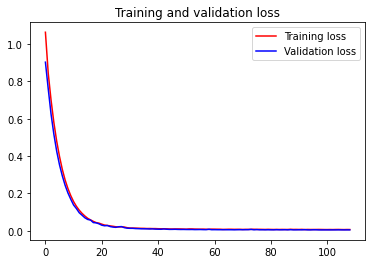

<Figure size 432x288 with 0 Axes>

In [83]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()


plt.show()

In [84]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
train_predict.shape, test_predict.shape

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


((495, 1), (200, 1))

# 5. Model Evaluation

In [85]:
# Transform back to original form

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1)) 
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1)) 

- ## Evaluation metrices RMSE, MSE and MAE

In [86]:
# Evaluation metrices RMSE and MAE
print("Train data RMSE: ", math.sqrt(mean_squared_error(original_ytrain,train_predict)))
print("Train data MSE: ", mean_squared_error(original_ytrain,train_predict))
print("Train data MAE: ", mean_absolute_error(original_ytrain,train_predict))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(original_ytest,test_predict)))
print("Test data MSE: ", mean_squared_error(original_ytest,test_predict))
print("Test data MAE: ", mean_absolute_error(original_ytest,test_predict))

Train data RMSE:  4.167776312690677
Train data MSE:  17.370359392625495
Train data MAE:  3.350080332129893
-------------------------------------------------------------------------------------
Test data RMSE:  3.730003073497564
Test data MSE:  13.912922928301272
Test data MAE:  2.745891571044922


- ## Variance Regression Score

In [87]:
print("Train data explained variance regression score:", 
      explained_variance_score(original_ytrain, train_predict))
print("Test data explained variance regression score:", 
      explained_variance_score(original_ytest, test_predict))

Train data explained variance regression score: 0.9459389813128594
Test data explained variance regression score: 0.8950054408862114


- ## R square score for regression

In [88]:
print("Train data R2 score:", r2_score(original_ytrain, train_predict))
print("Test data R2 score:", r2_score(original_ytest, test_predict))

Train data R2 score: 0.9458158290374868
Test data R2 score: 0.8906963187152516


- ## Regression Loss Mean Gamma deviance regression loss (MGD) and Mean Poisson deviance regression loss (MPD)

In [89]:
print("Train data MGD: ", mean_gamma_deviance(original_ytrain, train_predict))
print("Test data MGD: ", mean_gamma_deviance(original_ytest, test_predict))
print("----------------------------------------------------------------------")
print("Train data MPD: ", mean_poisson_deviance(original_ytrain, train_predict))
print("Test data MPD: ", mean_poisson_deviance(original_ytest, test_predict))

Train data MGD:  0.0013550586133763156
Test data MGD:  0.0009238373063946548
----------------------------------------------------------------------
Train data MPD:  0.15160297428188468
Test data MPD:  0.11284565478621601


- # Comparision of original Google Stock close price and predicted close price

In [90]:
# shift train predictions for plotting

look_back=time_step
trainPredictPlot = np.empty_like(closedf)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(closedf)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(closedf)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Original close price','Train predicted close price','Test predicted close price'])


plotdf = pd.DataFrame({'date': close_stock['Date'],
                       'original_close': close_stock['Close'],
                      'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['date'], y=[plotdf['original_close'],plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value':'Stock price','date': 'Date'})
fig.update_layout(title_text='Comparision between Google Stock original close price vs Google Stock predicted close price',
                  plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Train predicted data:  (741, 1)
Test predicted data:  (741, 1)


- # Predicting next 30 days

In [91]:
x_input=test_data[len(test_data)-time_step:].reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=time_step
i=0
pred_days = 30    # Prediction for next 30 days

while(i<pred_days):
    
    if(len(temp_input)>time_step):
        
        x_input=np.array(temp_input[1:])
        #print("{} day input {}".format(i,x_input))
        x_input = x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        
        yhat = model.predict(x_input, verbose=0)
        #print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
       
        lst_output.extend(yhat.tolist())
        i=i+1
        
    else:
        
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        
        lst_output.extend(yhat.tolist())
        i=i+1
               
print("Output of predicted next days: ", len(lst_output))

Output of predicted next days:  30


- # Plotting last 15 days of dataset and next predicted 30 days

In [92]:
last_days=np.arange(1,time_step+1)
day_pred=np.arange(time_step+1,time_step+pred_days+1)
print(last_days)
print(day_pred)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]
[23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46
 47 48 49 50 51 52]


In [93]:
# Initialize the template matrix with NaNs to hold both actual and predicted values
temp_mat = np.empty((len(last_days) + pred_days + 1, 1))
temp_mat[:] = np.nan

# Extract the last actual values and predicted values, then inverse transform them
last_original_days_value = temp_mat.flatten().tolist()
next_predicted_days_value = temp_mat.flatten().tolist()

last_original_days_value[:time_step] = scaler.inverse_transform(closedf[-time_step:]).flatten().tolist()
next_predicted_days_value[time_step:time_step + pred_days] = scaler.inverse_transform(np.array(lst_output).reshape(-1,1)).flatten().tolist()

# Create a DataFrame for the plot
new_pred_plot = pd.DataFrame({
    'last_original_days_value': last_original_days_value,
    'next_predicted_days_value': next_predicted_days_value
})

# Cycle through the names for the legend
names = cycle(['Last 15 days close price', 'Predicted next 30 days close price'])

# Create the plot
fig = px.line(new_pred_plot, x=new_pred_plot.index, y=['last_original_days_value', 'next_predicted_days_value'],
              labels={'value': 'Stock price', 'index': 'Timestamp'})

# Update the layout and add proper names to the traces
fig.update_layout(title_text='Compare last 15 days vs next 30 days',
                  plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='Close Price')

fig.for_each_trace(lambda t: t.update(name=next(names)))

# Update the axes
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

# Show the plot
fig.show()

- # Plotting entire Closing Google Stock Price with next 30 days period of prediction

In [94]:
lstmdf=closedf.tolist()
lstmdf.extend((np.array(lst_output).reshape(-1,1)).tolist())
lstmdf=scaler.inverse_transform(lstmdf).reshape(1,-1).tolist()[0]

names = cycle(['Close price'])

fig = px.line(lstmdf,labels={'value': 'Stock price','index': 'Timestamp'})
fig.update_layout(title_text='Plotting whole closing Google Stock price with prediction',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Stock')

fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

# Thanks

